In [1]:
import os
import shutil
import io
import subprocess
import PIL
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import RealTimePredictor 
from sagemaker.predictor import json_deserializer

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
### Importing fastai library
from fastai import *
from fastai.vision import *

## Data Collection

### Got the data from Kaggle competition  ''Plant Pathology 2020 - FGVC7"
- https://www.kaggle.com/c/plant-pathology-2020-fgvc7/data

### Data Preparation
    - Just want to split the data like
            - Data
                |__train
                       |__healthy
                       
                       |__multiple_diseases
                       
                       |__rust
                       
                       |__scab
                 
                 |__val
                       |__healthy
                       
                       |__multiple_diseases
                       
                       |__rust
                       
                       |__scab
                  
                 |__test
                       |__healthy
                       
                       |__multiple_diseases
                       
                       |__rust
                       
                       |__scab     

#### I was extracted zip file into 'Raw_Data' direcotry It consisting two '.csv' files and 'images' folder

In [21]:

DIR_INPUT = 'Raw_Data'
TRAIN_PATH = DIR_INPUT + "/train.csv" ### It consistind the name of train images under the column 'image_id' 
                                        # then remaining four columns representing classes
TEST_PATH = DIR_INPUT + "/test.csv"   ### It consistind the name of test images under the column 'image_id' but no labels
train_csv = pd.read_csv(TRAIN_PATH)
test_csv = pd.read_csv(TEST_PATH)
train_csv.head()                      ### Only consideing the 'train.csv'

image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

In [23]:
### decoding the labels
train_labels = train_csv.iloc[:, 1:]#.values # loast four columns i.e categories
train_labels['train_y'] = train_labels['healthy']  + train_labels['rust']*2 + train_labels['scab'] * 3 + train_labels['multiple_diseases'] *4
# rust=2, scab=3, healthy=1, muti_disease=4
train_labels.head()

healthy  multiple_diseases  rust  scab  train_y
0        0                  0     0     1        3
1        0                  1     0     0        4
2        1                  0     0     0        1
3        0                  0     1     0        2
4        1                  0     0     0        1

In [24]:
### dict of paths of images
root = DIR_INPUT + '/images/'
def Create_image_path_dict(df, root):
    image_paths = []
    for i in range(0, len(df)):
        image_src = root + df.loc[i, 'image_id'] + '.jpg'
        image_paths.append(image_src)
    image_paths = pd.DataFrame(image_paths)
    image_paths.columns = ['image_path']
    return image_paths

In [25]:
image_paths = Create_image_path_dict(train_csv, root)
image_paths['label'] = train_labels['train_y']
image_paths.head()

image_path  label
0  Raw_Data/images/Train_0.jpg      3
1  Raw_Data/images/Train_1.jpg      4
2  Raw_Data/images/Train_2.jpg      1
3  Raw_Data/images/Train_3.jpg      2
4  Raw_Data/images/Train_4.jpg      1

In [26]:
# Decode the labels
classes = ['healthy','rust','scab','multiple_diseases']
classes_dict = {i+1:label for i, label in enumerate(classes)}
image_paths = image_paths.replace(classes_dict)
image_paths.head()

image_path              label
0  Raw_Data/images/Train_0.jpg               scab
1  Raw_Data/images/Train_1.jpg  multiple_diseases
2  Raw_Data/images/Train_2.jpg            healthy
3  Raw_Data/images/Train_3.jpg               rust
4  Raw_Data/images/Train_4.jpg            healthy

In [27]:
### Train_test_split
from sklearn.model_selection import train_test_split
X = image_paths
y=image_paths.label
train, val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=464)
train, test, y_train, y_test = train_test_split( train, train.label, test_size=0.2, random_state=464)

train.head()

image_path              label
1679  Raw_Data/images/Train_1679.jpg               rust
1761  Raw_Data/images/Train_1761.jpg               scab
1264  Raw_Data/images/Train_1264.jpg  multiple_diseases
107    Raw_Data/images/Train_107.jpg               scab
42      Raw_Data/images/Train_42.jpg               scab

In [28]:
len(train), len(val), len(test)

(1019, 547, 255)

In [29]:
# #### Creating the Train_and_sub_folders
init_path = 'Data'
subfolder_names = classes
des_data_path = [init_path +'/'+ i for i in ['train','test','val']]
for path in des_data_path:
    for subfolder_name in subfolder_names:
        try:
            os.makedirs(os.path.join(path, subfolder_name))
        except:
            pass

In [30]:
# ### Moving the images to corresponding folders
def move_image(df,dst_root):
    for i in range(len(df)):
        image_src, sub_folder = df.iloc[i][0], df.iloc[i][1]
        dst = dst_root +'/' + sub_folder
        shutil.move(image_src, dst)

move_image(train, des_data_path[0])
move_image(test, des_data_path[1])
move_image(val, des_data_path[2])

#### The data arranged into corresponding directories

### Visualizing the sample images

In [24]:
path='Data'
tfms=get_transforms(flip_vert= True, max_rotate=90.0) ### Data Augmentation
data=None
data = ImageDataBunch.from_folder(path, train='train', valid='val', test='test', ds_tfms=tfms, size=224, bs=20).normalize(imagenet_stats)

['healthy', 'multiple_diseases', 'rust', 'scab']


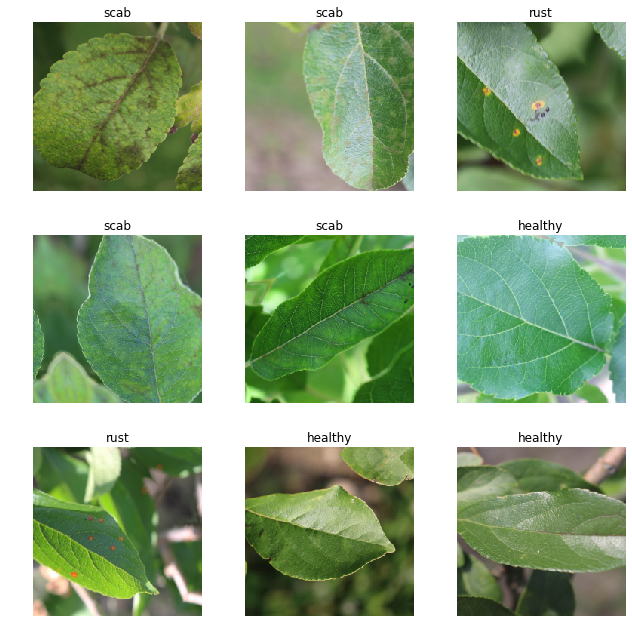

In [6]:
print(data.classes)
data.show_batch(rows=3, figsize=(9,9))

### Details of the data in directories

In [23]:
data

ImageDataBunch;

Train: LabelList (1019 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
rust,rust,rust,rust,rust
Path: Data;

Valid: LabelList (547 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
rust,rust,rust,rust,rust
Path: Data;

Test: LabelList (255 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: Data

### Creating and training the resnet18 model for understanding the optimized learning rate

#### Creating ResNet18 using fastai library and PyTorchModels. The model we are using is 'resnet18' and metric is 'accuracy'

In [4]:
### Ceating 'resnet18'
learn = cnn_learner(data, models.resnet18, metrics=[accuracy])

In [11]:
### Freezing the last convolutional layer
learn.freeze()

In [ ]:
### training the last layer with learning rates between (1e-07, 1e-02)
learn.fit_one_cycle(3, max_lr=slice(1e-07, 1e-02))

In [9]:
###  learning rate finder
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


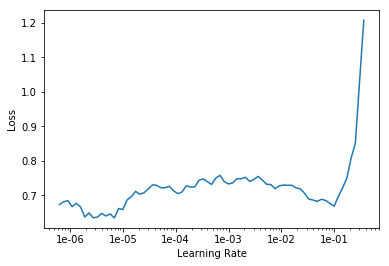

In [11]:
### Ploting lesrning rates verses training losses
learn.recorder.plot()

In [17]:
### Fitting for another 3 epochs
learn.fit(3, 0.001)

In [18]:
###  learning rate finder
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


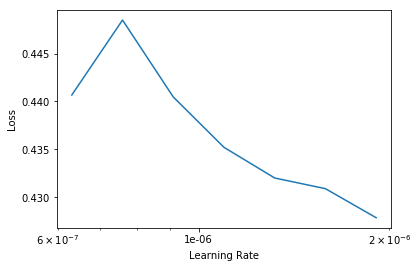

In [15]:
### plotting the learning rates
learn.recorder.plot()

In [26]:
# learn.lr_range()
learn.fit_one_cycle(1, max_lr=slice(1e-06,1e-04))

In [27]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


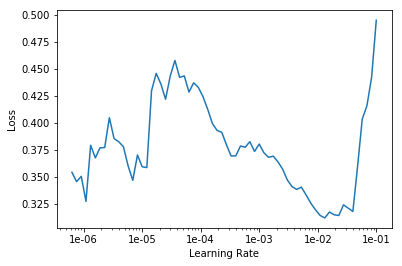

In [28]:
learn.recorder.plot()

#### I just want to pick my learning rate between 1e-03 to 1e-02  

In [66]:
# pets_predictor.delete_endpoint()

## Deploying the model for web app

#### creating sagemaker session and Uploding input data to sagemaker default s3 bucket

In [13]:
sagemaker_session = sagemaker.Session()
bucket = None
bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/fastai-leaf-disease-classification'

role = sagemaker.get_execution_role()

In [14]:
path = 'Data'
inputs = None
inputs = sagemaker_session.upload_data(path=path, bucket=bucket, key_prefix=prefix)
print('input spec (in this case, just an S3 path): {}'.format(inputs))

input spec (in this case, just an S3 path): s3://sagemaker-ap-south-1-884121885818/sagemaker/fastai-leaf-disease-classification


### Building and training the Pytorch model

#### Data preparation
- The fastai library is used on top of Pytorch predifined models. fastai default image transformation is applied to data
    

#### Training the model
    - Here we are using the pytorch pretrained model 'resnet18' architecture for training. The major parameters need to be passed to model for data
        - no. epochs = 20
        - learning rate = 0.001
        - optimizer : Adam
        - Loss_function : CrossEntropyLoss
        - metrics : Error rate = (1-accuray)
     - Initially all the layers of the model will be freezed only we train the last layer with the preprocessed input data to          the layer. Here the layer trained for number of epochs = 10
     - Then, Unfreezing the model
     - Now for epochs = 10, the model will get trained. 

#### The 'train.py' consisting the train function 

In [23]:
!pygmentize Web_app/train.py

import argparse
import logging
import sagemaker_containers
import requests

import os
import io
import glob
import time

from fastai.vision import *

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

# set the constants for the content types
JSON_CONTENT_TYPE = 'application/json'
TEXT_CONTENT_TYPE = 'text/plain'
JPEG_CONTENT_TYPE = 'image/jpeg'

def _train(args):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    logger.info("Device Type: {}".format(device))

    logger.info("Loading Pets dataset")
    print(f'Batch size: {args.batch_size}')
    path = Path(args.data_dir)
        
    # get the pattern to select the training/validation data
    np.random.seed(2)
    print('Creating DataBunch object')
    
    data = ImageDataBunch.from_folder(path,
                                      train='train',
                                      valid='val',
                                      test='test',
                                      ds_tfms=get_tran

In [15]:
### Creating Pytorch estimator
apl_leaf_disease_estimator = PyTorch(entry_point='Web_app/train.py',
                         base_job_name='fastai-leaf-disease-cl-job',
                         role=role,
                         framework_version='1.0.0',
                         train_instance_count=1,
                         train_instance_type='ml.p2.xlarge')

#### Training the model

In [25]:
apl_leaf_disease_estimator.fit(inputs)

2020-04-12 18:00:51 Starting - Starting the training job...
2020-04-12 18:00:53 Starting - Launching requested ML instances...
2020-04-12 18:01:51 Starting - Preparing the instances for training......
2020-04-12 18:02:50 Downloading - Downloading input data......
2020-04-12 18:03:25 Training - Downloading the training image...
2020-04-12 18:04:18 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-04-12 18:04:19,517 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-04-12 18:04:19,543 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-04-12 18:04:20,155 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-04-12 18:04:20,395 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2020-04-12 18:04:20,395 sagemak

### Model Deployment

#### Create 'RealTimePredictor' class 
    - for serialization of input data and deserialization of result data can be configured through initializer arguments.
    If not specified, a sequence of bytes is expected and the API sends it in the request body without modifications.
    In response, the API returns the sequence of bytes from the prediction result without any modifications.

In [70]:
#First we need to create a RealTimePredictor class to accept jpeg images/path of a image as input and output JSON.
#The default behaviour is to accept a numpy array.

class ImagePredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(endpoint_name, sagemaker_session=sagemaker_session, serializer=None, 
                                            deserializer=json_deserializer, content_type='text/plain')

#### Creating PyTorchModel object

In [71]:
apple_leaf_disease_cl_model=PyTorchModel(model_data=apl_leaf_disease_estimator.model_data,
                        name=apl_leaf_disease_estimator._current_job_name,
                        role=role,
                        framework_version=apl_leaf_disease_estimator.framework_version,
                        entry_point=apl_leaf_disease_estimator.entry_point,
                        predictor_cls=ImagePredictor)

In [72]:
### Model deployment/ Creating e
apple_leaf_disease_predictor = apple_leaf_disease_cl_model.deploy(initial_instance_count=1,
                                       instance_type='ml.t2.medium')

Using already existing model: fastai-leaf-disease-cl-job-2020-04-10-16-37-30-782


-----------!

In [73]:
apple_leaf_disease_predictor.endpoint

'fastai-leaf-disease-cl-job-2020-04-10-16-37-30-782'

#### passing the new image downloaded from web

In [14]:
url = 'https://netreefruit.org/sites/netreefruit.org/files/images/apple_scab_early_jc_sm.jpg'

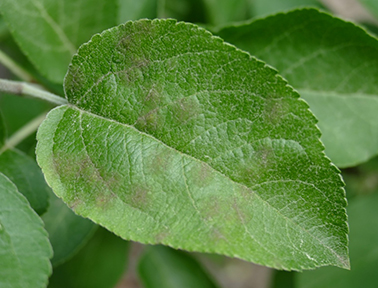

In [69]:
### Visualing the image
img_bytes = requests.get(url, stream=True)
img = PIL.Image.open(io.BytesIO(img_bytes.content))
img

In [77]:
### Passing URL as text input to model
response = apple_leaf_disease_predictor.predict(url)
response

{'class': 'scab', 'confidence': 0.5285229086875916}

#### Passisng another image of class 'rust'

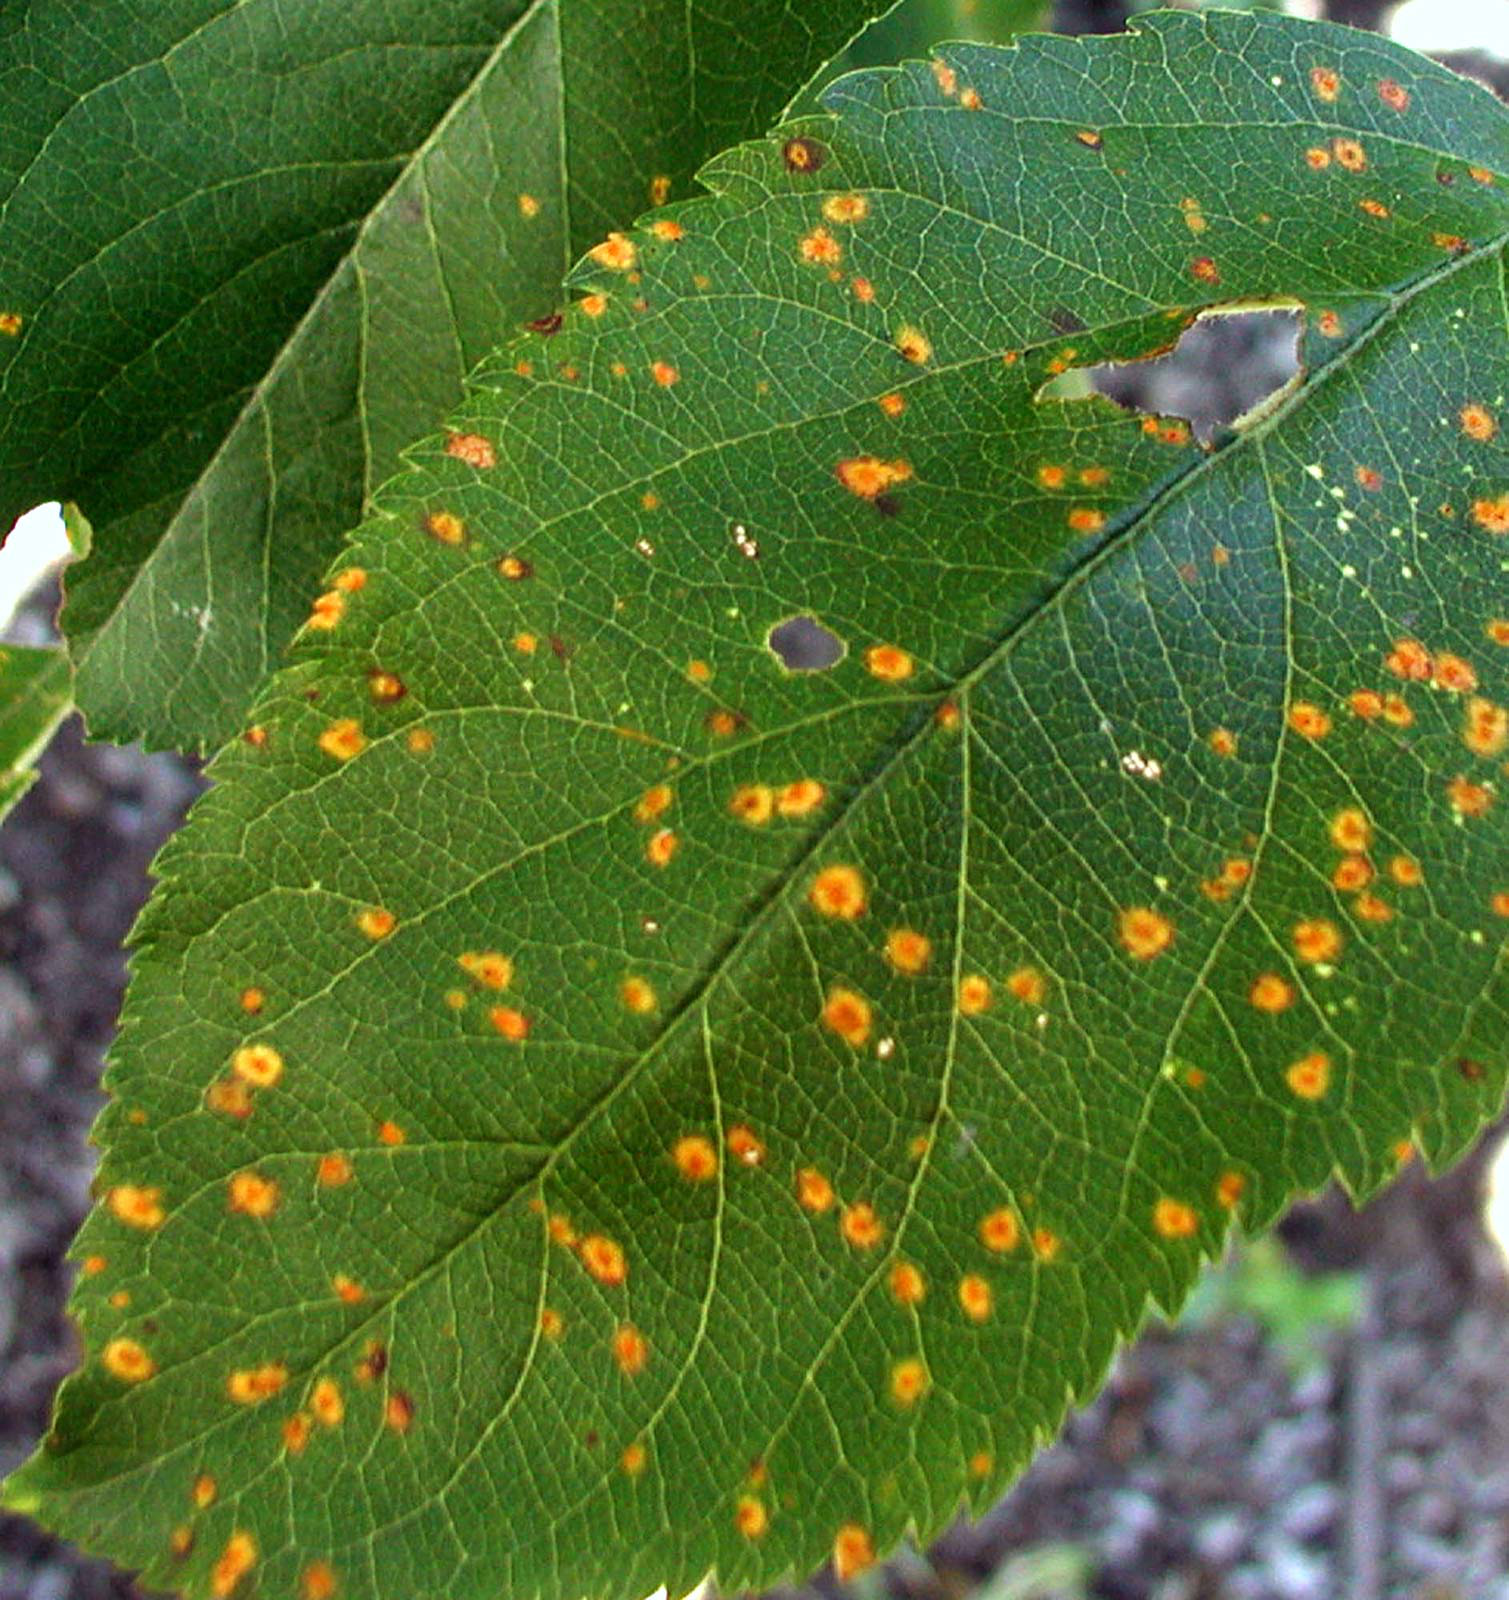

In [81]:
url1 = 'https://cdn.britannica.com/61/185161-050-726ED959/spots-Orange-cedar-apple-rust-disease-apple-leaf.jpg'
img_bytes = requests.get(url1, stream=True)
img = PIL.Image.open(io.BytesIO(img_bytes.content))
img

In [80]:
response = apple_leaf_disease_predictor.predict(url1)
response

{'class': 'rust', 'confidence': 0.9981130361557007}

#### here got better probability for right class

### Can also pass the Image as input just passing the content type as ''image/jpeg' to 'RealTimePredictor' class.

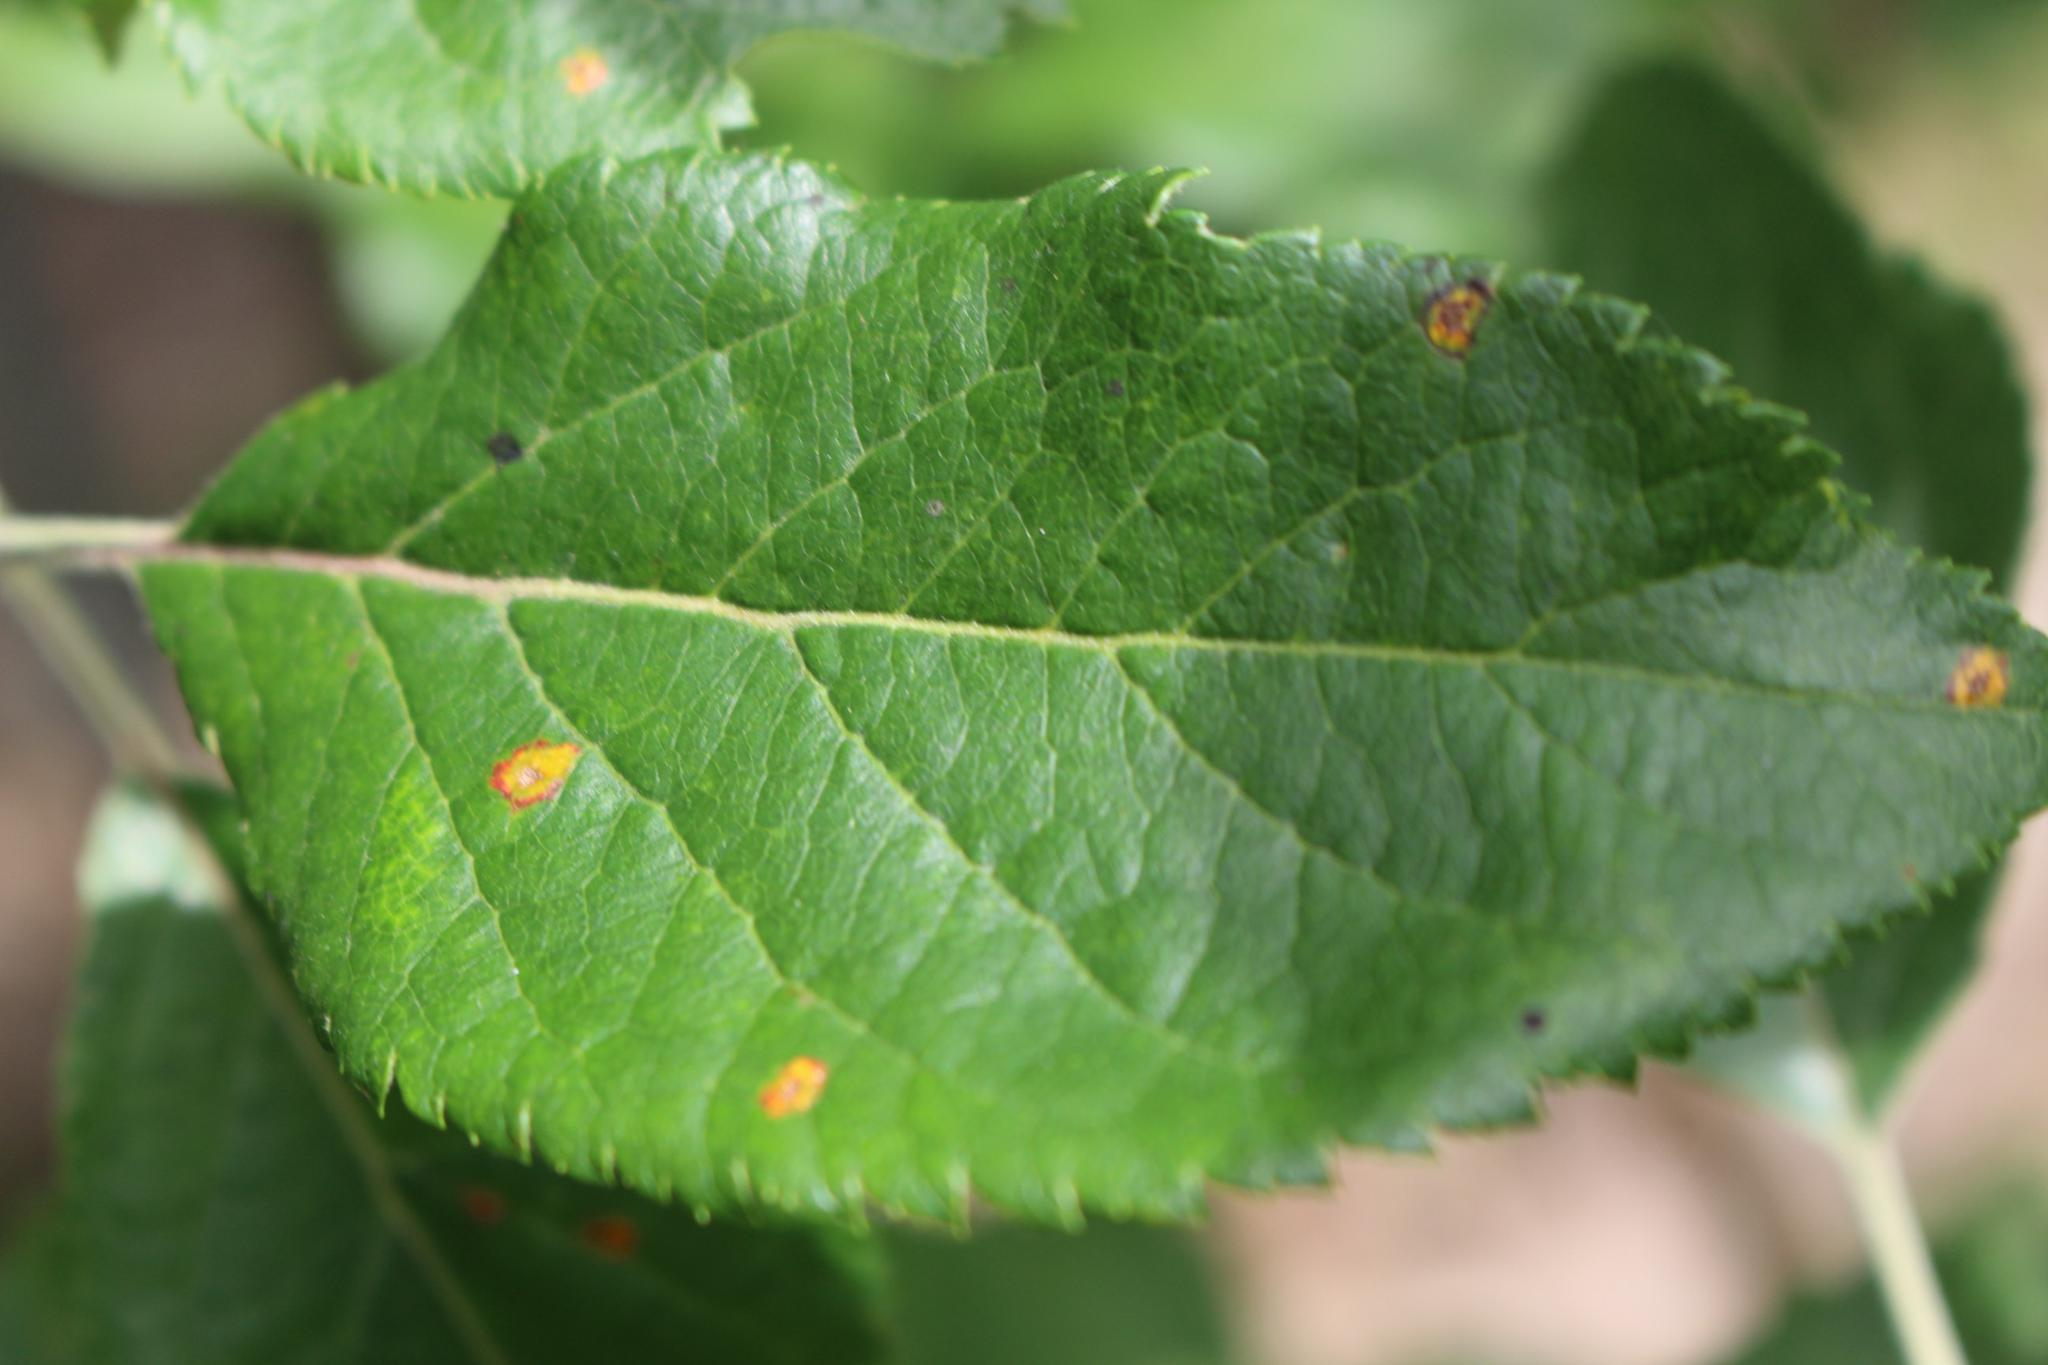

In [32]:
file_name = 'Data/test/rust/Train_1022.jpg'
# test image
from IPython.display import Image
test_image = Image(file_name)
test_image

In [50]:
from io import BytesIO
from PIL import Image

with BytesIO() as output:
    with Image.open(file_name) as img:
        img.save(output, 'jpeg')
    img = output.getvalue()
type(img)

bytes

In [51]:
response = pets_predictor.predict(img)
response

{'class': 'rust', 'confidence': 0.9881226420402527}

### Next created IAM Role for Lambda Function and Created Lamda Funtion

In [14]:
### Will copy this code to Lambda function code editor window and saved
# !pygmentize Web_app/lambda_function.py

import boto3

def lambda_handler(event, context):

    # The SageMaker runtime is what allows us to invoke the endpoint that we've created.
    runtime = boto3.Session().client('sagemaker-runtime')

    # Now we use the SageMaker runtime to invoke our endpoint, sending the review we were given
    response = runtime.invoke_endpoint(EndpointName = 'fastai-leaf-disease-cl-job-2020-04-10-16-37-30-782',    # The name of the endpoint we created
                                       ContentType = 'text/plain',                 # The data format that is expected. here it is URL
                                       Body = event['body'])                       # The actual review

    # The response is an HTTP response whose body contains the result of our inference
    result = response['Body'].read().decode('utf-8')

    return {
        'statusCode' : 200,
        'headers' : { 'Content-Type' : 'text/plain', 'Access-Control-Allow-Origin' : '*' },
        'body' : result
    }


### Note 'pr

#### Name of the Endpoint need to be passed to Lamda Function

In [78]:
apple_leaf_disease_predictor.endpoint

'fastai-leaf-disease-cl-job-2020-04-10-16-37-30-782'

#### Then created API gateway to create API to trigger created Lambda function

### WOW!!!  Got the Web link
    --> https://eezs416ebj.execute-api.ap-south-1.amazonaws.com/production

In [ ]:
### Finally created a index.html file with generated web link

#### Deleting Endpoint

In [82]:
apple_leaf_disease_predictor.delete_endpoint()